# MNIST Dataset com MLP

O dataset MNIST (Modified National Institute of Standards and Technology) é amplamente utilizado no campo de machine learning e visão computacional para o treinamento e teste de modelos de reconhecimento de padrões, especialmente redes neurais. Ele consiste em 70.000 imagens em escala de cinza de dígitos manuscritos (0 a 9), sendo 60.000 para treinamento e 10.000 para teste. Cada imagem tem uma resolução de 28x28 pixels, onde cada pixel possui um valor de intensidade variando de 0 (preto) a 255 (branco).

## Importe de Bibliotecas e Dowload do Dataset

In [1]:
import torch
import torchvision
import torchvision.models as models # Possibilita o save e load dos modelos
import torch.nn.functional as F # Dá acesso às funções de ativação e de perda
import torch.optim as optim # Dá acesso a diversos otimizadores
import torch.nn as nn # Possiblita criar a rede neural
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

Outra possibilidade de dataset é o Fashion MNIST. Neste caso, temos imagens 28x28 pixels em escala de cinza acerca de 10 categorias relacionadas a roupas, como camiseta, calça e tênis.

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17614102.58it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 476014.50it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4434304.07it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2939896.41it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Criação dos Dataloaders e Visualização dos Dados

In [3]:
# batch_size: tamanho de cada lote
# shuffle: embaralhamento do dataset após cada época de treinamento (ajuda a evitar overfitting)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

data: torch.Size([64, 1, 28, 28]) type: torch.FloatTensor
target: torch.Size([64]) type: torch.LongTensor


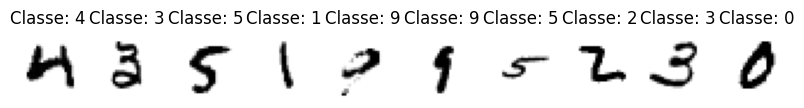

In [ ]:
for (data, target) in train_dataloader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Classe: '+str(target[i].item()))

## Criação da Rede

Outras funções de ativação comuns:


*   nn.Sigmoid()
*   nn.Softplus()
*   nn.Tanh()



In [4]:
# Criação de uma classe derivada de nn.Module
class NetWork(nn.Module):
    def __init__(self):
        super().__init__()

        # Definição das camadas da rede
        # nn.Flatten() converte a matriz da imagem para um vetor unidimensional
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    # Definição da propagação dos inputs x pels rede
    def forward(self, x):
        return self.layers(x)

Cross Entropy:
  Dadas as saídas da última camada da rede, podemos utilizar algumas estratégias para melhorar a interpretabilidade dos dados. Dentre elas, está a aplicação da função de ativção softmax, conforme segue:

  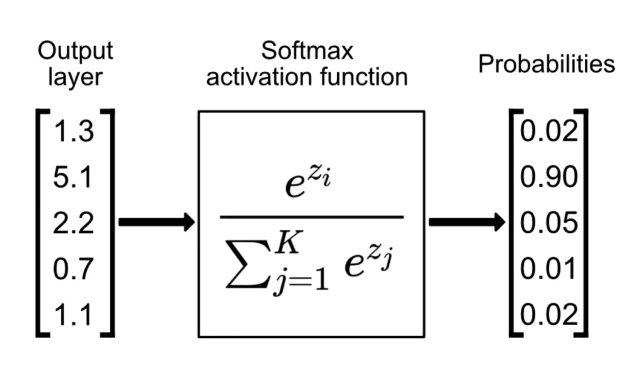

  Com isso, podemos aplicar a função CrossEntropy aos novos valores:

  $$
  CE(p_i) = -\sum_{i = 1}^{n} P(i) \cdot log(p(i))
  $$

In [5]:
# Verifica se é possível alocar uma GPU. Senão, aloca uma CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

# Instancia o modelo e transfere para device
model = NetWork().to(device)
print(model)

# Função de perda
loss_function = nn.CrossEntropyLoss()

# Otimizador (lr -> taxa de aprendizado)
optimizer = optim.SGD(model.parameters(), lr = 0.001)

Rodando na cuda
NetWork(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU()
    (5): Linear(in_features=50, out_features=10, bias=True)
  )
)


## Treinamento do Modelo

In [6]:
# Calcula a quantidade de predições acertadas
def correct(output, target):
    # Obtém o output de maior valor (predição)
    predicted_digits = output.argmax(1)
    correct_ones = (predicted_digits == target).type(torch.float)
    return correct_ones.sum().item()

In [7]:
# Define o treinamento do modelo
def train(model, dataloader, lossfunc, optimizer):
    model.train()

    # Total de batches
    num_batches = len(dataloader)

    # Total de amostras no dataset
    num_items = len(dataloader.dataset)

    # Perda e precisão acumuladas
    cum_loss = 0.0
    cum_correct = 0.0

    for data, target in dataloader:
        data = data.to(device)
        target = target.to(device)

        # Obtém as saídas da última camada
        output = model(data)

        # Calcula a perda
        loss = lossfunc(output, target)

        cum_loss += loss
        cum_correct += correct(output, target)

        # Calcula as derivadas pelo backpropagation
        loss.backward()

        # Atualiza os pesos
        optimizer.step()

        # Zera as derivadas
        optimizer.zero_grad()

    train_loss = cum_loss/num_batches
    accuracy = cum_correct/num_items
    print(f"Perda Média: {train_loss:7f}, precisão: {accuracy:.2%}")

In [10]:
%%time

epochs = 15
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(model, train_dataloader, loss_function, optimizer)

Training epoch: 1
Perda Média: 2.295493, precisão: 11.37%
Training epoch: 2
Perda Média: 2.271132, precisão: 17.08%
Training epoch: 3
Perda Média: 2.234533, precisão: 27.66%
Training epoch: 4
Perda Média: 2.175642, precisão: 41.95%
Training epoch: 5
Perda Média: 2.081007, precisão: 55.04%
Training epoch: 6
Perda Média: 1.934949, precisão: 60.33%
Training epoch: 7
Perda Média: 1.728839, precisão: 63.64%
Training epoch: 8
Perda Média: 1.476353, precisão: 67.54%
Training epoch: 9
Perda Média: 1.221209, precisão: 72.22%
Training epoch: 10
Perda Média: 1.015930, precisão: 76.28%
Training epoch: 11
Perda Média: 0.870649, precisão: 78.96%
Training epoch: 12
Perda Média: 0.768918, precisão: 80.85%
Training epoch: 13
Perda Média: 0.694444, precisão: 82.17%
Training epoch: 14
Perda Média: 0.637888, precisão: 83.35%
Training epoch: 15
Perda Média: 0.593346, precisão: 84.36%
CPU times: user 1min 55s, sys: 721 ms, total: 1min 56s
Wall time: 1min 57s


## Teste do Modelo

In [11]:
# Define o treinamento do modelo
def test(model, dataloader, lossfunc):
    model.eval()

    num_batches = len(dataloader)
    num_items = len(dataloader.dataset)

    cum_loss = 0.0
    cum_correct = 0.0

    # Desabilita o cálculo do gradiente
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)

            loss = lossfunc(output, target)

            cum_loss += loss
            cum_correct += correct(output, target)

    train_loss = cum_loss/num_batches
    accuracy = cum_correct/num_items
    print(f"Perda Média: {train_loss:7f}, precisão: {accuracy:.2%}")

In [12]:
test(model, test_dataloader, loss_function)

Perda Média: 0.555768, precisão: 85.14%


## Salvamento e Carregamento do Modelo

In [13]:
torch.save(model.state_dict(), 'model_weights.pth')

In [14]:
model2 = NetWork()
model2 = torch.load('model_weights.pth', weights_only=True)